# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [86]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [87]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<Axes: xlabel='week'>

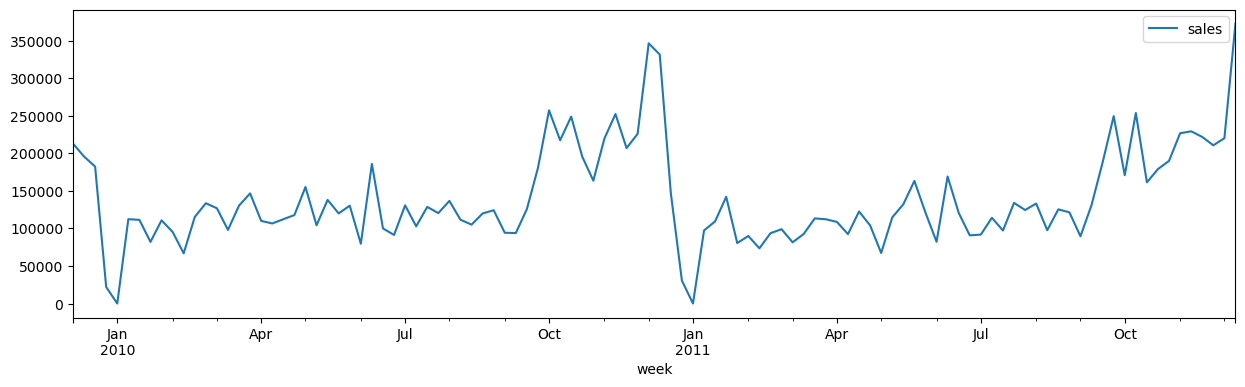

In [88]:
df.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [89]:
# Create the feature month from the timestamp.
# Datetime features

dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month"
    ],
)

In [90]:
# Transform the month with the sine and cosine functions
cyclical = CyclicalFeatures(
    variables=["month"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)


In [91]:
# Create the feature lag-1 by lagging 1 week of data.
# Shift the data "sales" in freq of week 

lagf = LagFeatures(
    variables=["sales"],  # the input variables
    freq=["1W"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)


In [92]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf = WindowFeatures(
    variables=["sales"],  # the input variables
    window=[2, 4],  # Use integer values for the number of periods
    missing_values="ignore",
    functions=["mean", "max", "min"]
)

In [93]:
# Drop missing data.
imputer = DropMissingData()

In [94]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=["sales"])

# Features engineering pipline

In [95]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclical),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [106]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [107]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [96]:
# Split the data.
# (Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))
# input data
X_train = df[df.index < "2011-6-11"]
X_test = df[df.index >= pd.Timestamp("2011-6-11") - pd.offsets.Hour(24)]

# target
y_train = df[df.index < "2011-6-11"]["sales"]
y_test = df[df.index >= pd.Timestamp("2011-6-11") - pd.offsets.Hour(24)]["sales"]

In [103]:
X_train_t = pipe.fit_transform(X_train)

In [105]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.
print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(79,)
(75,)


In [14]:
# Target (in this dataset, is is the train set itself)

## Machine Learning

In [108]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  0.0016431201338833559
test rmse:  0.00203486529442332


In [118]:
preds = linear_model.predict(X_train)

In [119]:
len(preds), len(y_train_t)

(79, 75)

Text(0.5, 1.0, 'Forecast: test set')

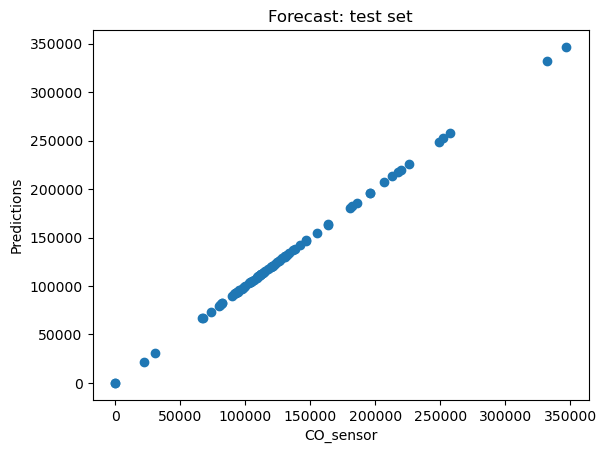

In [121]:

plt.scatter(y_train, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: test set")

In [122]:
preds = linear_model.predict(X_test)

In [124]:
preds

array([169194.04892045, 120797.68022707,  90786.39103733,  91812.15100964,
       114199.46040522,  97244.71086297, 134081.77986842, 124542.86112596,
       133155.36989344,  97651.84085198, 125420.95010225, 121444.74020961,
        89577.65106997, 131164.23994719, 187934.49841449, 249563.04775061,
       170904.19987428, 253713.53663855, 161438.53912983, 179106.06865284,
       190034.1983578 , 226770.52736597, 229378.00729558, 221870.28749827,
       210741.75779873, 220213.98754299, 372946.25341946])